Starting gamma evaluations without multiprocessing...

Processing gamma 1/100: gamma = 0.99
Evaluating gamma = 0.99
Iteration 10: delta = 8.16e-01
Iteration 20: delta = 7.05e-01
Iteration 30: delta = 5.99e-01
Iteration 40: delta = 5.02e-01
Iteration 50: delta = 4.15e-01
  Trial 10/10 completed.
  Average Reward for gamma=0.99: 53.31

Processing gamma 2/100: gamma = 0.99
Evaluating gamma = 0.99
Iteration 10: delta = 8.17e-01
Iteration 20: delta = 7.07e-01
Iteration 30: delta = 6.01e-01
Iteration 40: delta = 5.04e-01
Iteration 50: delta = 4.17e-01
  Trial 10/10 completed.
  Average Reward for gamma=0.99: 53.81

Processing gamma 3/100: gamma = 0.99
Evaluating gamma = 0.99
Iteration 10: delta = 8.18e-01
Iteration 20: delta = 7.08e-01
Iteration 30: delta = 6.03e-01
Iteration 40: delta = 5.06e-01
Iteration 50: delta = 4.19e-01
  Trial 10/10 completed.
  Average Reward for gamma=0.99: 57.01

Processing gamma 4/100: gamma = 0.99
Evaluating gamma = 0.99
Iteration 10: delta = 8.18e-01
Iteration 

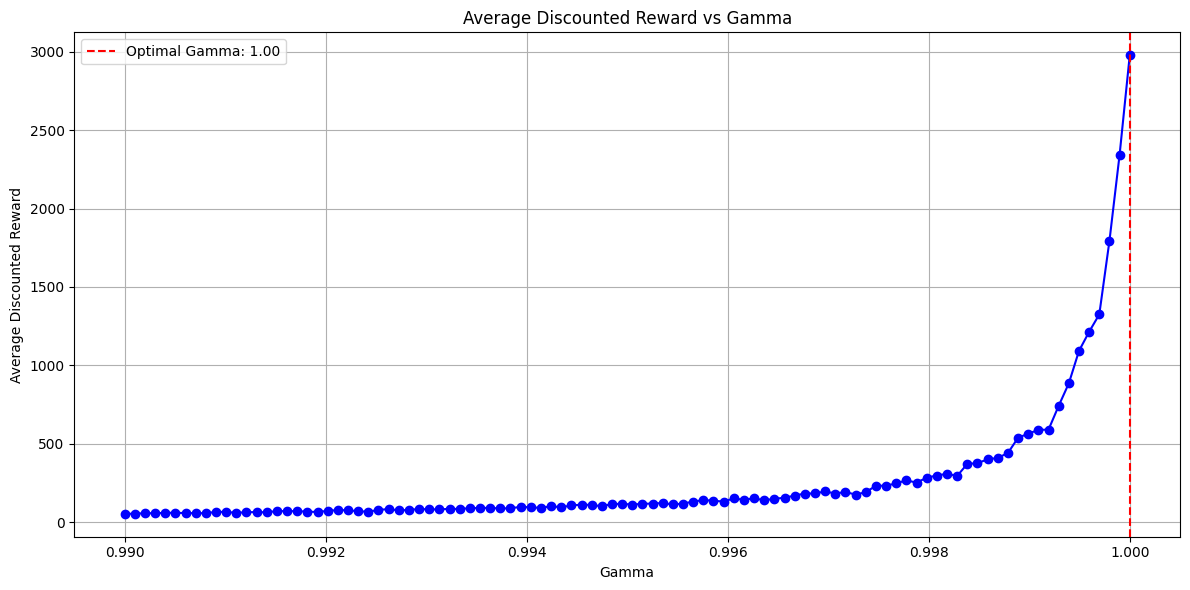

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Dynamic Programming Function
def solve_2armed_bandit_dp(M=10, gamma=0.95, tol=1e-8, max_iter=50):
    """
    Solve the 2-armed Beta-Bernoulli bandit using 4D dynamic programming.

    Arguments:
    ----------
    M : int
        Truncation level for alpha_i, beta_i.
    gamma : float
        Discount factor in (0,1).
    tol : float
        Convergence tolerance for the value iteration.
    max_iter : int
        Maximum number of iterations to run.

    Returns:
    --------
    R : 4D numpy array, shape (M+1, M+1, M+1, M+1)
        The approximate value function.
    policy : 4D numpy array of 0 or 1
        Optimal action: 0 for arm1, 1 for arm2.
    """
    # Initialize value function and policy arrays
    R = np.zeros((M+1, M+1, M+1, M+1), dtype=np.float64)
    policy = np.zeros((M+1, M+1, M+1, M+1), dtype=int)

    def clamp(x):
        return min(x, M)

    for it in range(max_iter):
        delta = 0.0  # Maximum change in this iteration

        # Iterate over all possible states
        for alpha1 in range(1, M+1):
            for beta1 in range(1, M+1):
                for alpha2 in range(1, M+1):
                    for beta2 in range(1, M+1):
                        # Compute expected reward for choosing arm 1
                        p1 = alpha1 / (alpha1 + beta1)
                        R_success_1 = R[clamp(alpha1 + 1), beta1, alpha2, beta2]
                        R_fail_1 = R[alpha1, clamp(beta1 + 1), alpha2, beta2]
                        R1 = p1 * (1.0 + gamma * R_success_1) + (1.0 - p1) * (gamma * R_fail_1)

                        # Compute expected reward for choosing arm 2
                        p2 = alpha2 / (alpha2 + beta2)
                        R_success_2 = R[alpha1, beta1, clamp(alpha2 + 1), beta2]
                        R_fail_2 = R[alpha1, beta1, alpha2, clamp(beta2 + 1)]
                        R2 = p2 * (1.0 + gamma * R_success_2) + (1.0 - p2) * (gamma * R_fail_2)

                        # Choose the action with the higher expected reward
                        new_val = max(R1, R2)

                        # Update the value function
                        old_val = R[alpha1, beta1, alpha2, beta2]
                        diff = abs(new_val - old_val)
                        if diff > delta:
                            delta = diff
                        R[alpha1, beta1, alpha2, beta2] = new_val

                        # Update the policy
                        if R1 > R2:
                            policy[alpha1, beta1, alpha2, beta2] = 0  # Choose arm1
                        else:
                            policy[alpha1, beta1, alpha2, beta2] = 1  # Choose arm2

        # Check for convergence
        if (it + 1) % 10 == 0 or delta < tol:
            print(f"Iteration {it + 1}: delta = {delta:.2e}")
        if delta < tol:
            print(f"Converged after {it + 1} iterations with delta={delta:.2e}")
            break
    else:
        print(f"Warning: Did not converge after {max_iter} iterations. Final delta={delta:.2e}")

    return R, policy

# Simulation Parameters
true_theta = [0.3, 0.6]        # True success probabilities for arm 1 and arm 2
alpha_prior = [1, 1]           # Prior alpha parameters for Beta distributions
beta_prior = [1, 1]            # Prior beta parameters for Beta distributions
gamma_values = np.linspace(0.99, 1.00, 100)  # Gamma values 
time_steps = 5000              # Number of pulls per trial
repeat_time = 10               # Number of trials per gamma
M = 10                         # Truncation level for DP

# Simulation Function
def simulate_trial(policy, M, true_theta, alpha_prior, beta_prior, gamma, time_steps):
    """
    Simulate a single trial of the bandit problem using the provided policy.

    Arguments:
    ----------
    policy : 4D numpy array
        Optimal policy derived from DP.
    M : int
        Truncation level.
    true_theta : list of float
        True success probabilities for each arm.
    alpha_prior : list of int
        Prior alpha parameters for Beta distributions.
    beta_prior : list of int
        Prior beta parameters for Beta distributions.
    gamma : float
        Discount factor.
    time_steps : int
        Number of pulls in the trial.

    Returns:
    --------
    total_reward : float
        Total discounted reward accumulated in the trial.
    """
    # Initialize Beta parameters
    alpha = [alpha_prior[0], alpha_prior[1]]
    beta = [beta_prior[0], beta_prior[1]]
    total_reward = 0.0
    current_gamma_power = 1.0  # gamma^{t-1}, starts at t=1

    for t in range(1, time_steps + 1):
        # Current state with truncation
        a1 = min(alpha[0], M)
        b1 = min(beta[0], M)
        a2 = min(alpha[1], M)
        b2 = min(beta[1], M)

        # Determine action from policy
        action = policy[a1, b1, a2, b2]

        # Pull the selected arm
        arm = action  # 0 or 1
        success = np.random.rand() < true_theta[arm]
        if success:
            total_reward += current_gamma_power  # Reward is gamma^{t-1}
            alpha[arm] += 1
        else:
            beta[arm] += 1

        # Update the discount factor for the next time step
        current_gamma_power *= gamma

    return total_reward

# Gamma Evaluation Function
def evaluate_gamma(gamma):
    """
    Evaluate a single gamma value by solving DP and running simulations.

    Arguments:
    ----------
    gamma : float
        Discount factor.

    Returns:
    --------
    gamma : float
        The gamma value evaluated.
    average_reward : float
        Average total discounted reward over all trials.
    """
    print(f"Evaluating gamma = {gamma:.2f}")

    # Solve DP to get the policy
    R, policy = solve_2armed_bandit_dp(M=M, gamma=gamma)

    # Initialize total rewards for all trials
    total_rewards = np.zeros(repeat_time, dtype=np.float64)

    # Simulate all trials
    for trial in range(1, repeat_time + 1):
        reward = simulate_trial(
            policy, M, true_theta, alpha_prior, beta_prior, gamma, time_steps
        )
        total_rewards[trial - 1] = reward
        if trial % 10 == 0 or trial == repeat_time:
            print(f"  Trial {trial}/{repeat_time} completed.")

    # Calculate average reward
    average_reward = np.mean(total_rewards)

    print(f"  Average Reward for gamma={gamma:.2f}: {average_reward:.2f}\n")

    return gamma, average_reward

# Main Execution
if __name__ == "__main__":
    # Initialize a list to store results
    results = []

    # Total number of gamma values
    total_gammas = len(gamma_values)

    print("Starting gamma evaluations without multiprocessing...\n")

    # Iterate over gamma_values and collect results
    for idx, gamma in enumerate(gamma_values, 1):
        print(f"Processing gamma {idx}/{total_gammas}: gamma = {gamma:.2f}")
        gamma_result = evaluate_gamma(gamma)
        results.append(gamma_result)

    print("All gamma values have been evaluated.\n")

    # Unpack results
    gamma_evaluated, avg_rewards = zip(*results)

    # Convert to numpy arrays for easier processing
    gamma_evaluated = np.array(gamma_evaluated)
    avg_rewards = np.array(avg_rewards)

    # Find the gamma with the highest average reward
    optimal_index = np.argmax(avg_rewards)
    optimal_gamma = gamma_evaluated[optimal_index]
    optimal_reward = avg_rewards[optimal_index]

    print(f"Optimal gamma: {optimal_gamma:.2f}")
    print(f"Average Discounted Reward: {optimal_reward:.2f}")

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(gamma_evaluated, avg_rewards, marker='o', linestyle='-', color='blue')
    plt.xlabel('Gamma')
    plt.ylabel('Average Discounted Reward')
    plt.title('Average Discounted Reward vs Gamma')
    plt.axvline(optimal_gamma, color='red', linestyle='--', label=f'Optimal Gamma: {optimal_gamma:.2f}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()